<a href="https://colab.research.google.com/github/OJB-Quantum/Qiskit-Metal-to-Litho/blob/main/Qiskit_Metal_Fully_in_Google_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Headless preflight (Qt off) + deps
import os
os.environ["QT_QPA_PLATFORM"] = "offscreen"
os.environ["MPLBACKEND"] = "Agg"

import matplotlib as mpl
try:
    mpl.use("Agg", force=True)
except TypeError:
    mpl.use("Agg")
print("Matplotlib backend:", mpl.get_backend())

# Scientific + GDS toolchain (incl. Descartes)
%pip -q install --upgrade pip wheel setuptools
%pip -q install "numpy>=1.24" "matplotlib>=3.8" \
                "gdstk>=0.9.61" "shapely>=2.0" "ezdxf>=1.2.0" \
                "pandas>=2.0" "scipy>=1.10" "networkx>=2.8" \
                "pint>=0.20" "addict>=2.4.0" "pyyaml>=6.0.1" \
                "qutip>=4.7" "h5py>=3.8" "descartes>=1.1" "jedi>=0.19.1"


Matplotlib backend: Agg
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 53.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.


In [2]:
#@title Clone Metal; bind to /content/qiskit-metal; headless, layout-only init (Dict + is_component)
# pylint: disable=invalid-name
import os, sys, re, textwrap
from pathlib import Path

# Fresh clone
!rm -rf /content/qiskit-metal
!git clone --depth 1 https://github.com/qiskit-community/qiskit-metal /content/qiskit-metal

root = Path("/content/qiskit-metal")
pkg  = root / "qiskit_metal"
assert pkg.exists(), f"Package folder missing: {pkg}"

# Force Python to import FROM THIS FOLDER (no editable install)
if str(root) not in sys.path:
    sys.path.insert(0, str(root))
os.environ["PYTHONPATH"] = str(root) + (":" + os.environ.get("PYTHONPATH",""))

# --- Replace qiskit_metal/__init__.py with a minimal but compatible headless init ---
orig_init = (pkg / "__init__.py").read_text(encoding="utf-8")
(pkg / "__init__orig.py").write_text(orig_init, encoding="utf-8")

minimal_init = textwrap.dedent("""
    # [colab] Headless, layout-only __init__ (no GUI, no analyses), keep essentials.
    import logging as _logging
    try:
        from addict import Dict as Dict
    except Exception:
        from .toolbox_python.attr_dict import Dict

    logger = _logging.getLogger("qiskit_metal_colab")

    class _Config:
        @staticmethod
        def is_building_docs():
            return False
    config = _Config()

    def is_design(obj):
        try:
            from .designs.design_base import QDesign
            return isinstance(obj, QDesign)
        except Exception:
            return False

    def is_component(obj):
        try:
            from .qlibrary.core.base import QComponent
            return isinstance(obj, QComponent)
        except Exception:
            return False

    __all__ = ["Dict", "config", "logger", "is_design", "is_component"]
""").strip()+"\n"
(pkg / "__init__.py").write_text(minimal_init, encoding="utf-8")

# --- Scrub ALL draw.mpl imports to avoid PySide2 at import time ---
draw_init = pkg / "draw" / "__init__.py"
if draw_init.exists():
    d = draw_init.read_text(encoding="utf-8")
    # Guard "from . import mpl"
    d = re.sub(r'^\s*from\s+\.\s*import\s+mpl\s*$',
               "try:\n    from . import mpl\n"
               "except Exception as _e:\n"
               "    print('[colab] draw.mpl disabled (headless):', _e)\n",
               d, flags=re.MULTILINE)
    # Guard "from .mpl import ..." and any other .mpl imports
    d = re.sub(r'^\s*from\s+\.\s*mpl\s+import[^\n]*$',
               "try:\n    from .mpl import render, figure_spawn\n"
               "except Exception as _e:\n"
               "    print('[colab] draw.mpl (named) disabled (headless):', _e)\n"
               "    def render(*a, **k):\n"
               "        raise RuntimeError('draw.mpl unavailable in headless mode')\n"
               "    def figure_spawn(*a, **k):\n"
               "        raise RuntimeError('draw.mpl unavailable in headless mode')\n",
               d, flags=re.MULTILINE)
    draw_init.write_text(d, encoding="utf-8")

# Optional: ensure renderers package never drags Qt; keep explicit imports only
rndr_init = pkg / "renderers" / "__init__.py"
if rndr_init.exists():
    (rndr_init.parent / "__init__orig.py").write_text(rndr_init.read_text(encoding="utf-8"), encoding="utf-8")
    rndr_init.write_text("# [colab] minimal renderers package (explicit imports only; no Qt/MPL)\n__all__ = []\n",
                         encoding="utf-8")

# Verify: import the package *from this folder* and keep it light
import importlib, sys as _sys
importlib.invalidate_caches()
import qiskit_metal
print("qiskit_metal from:", qiskit_metal.__file__)
assert qiskit_metal.__file__.startswith(str(pkg)), "Not importing from /content/qiskit-metal!"


Cloning into '/content/qiskit-metal'...
remote: Enumerating objects: 1050, done.
remote: Counting objects: 100% (1050/1050), done.
remote: Compressing objects: 100% (952/952), done.
remote: Total 1050 (delta 166), reused 672 (delta 88), pack-reused 0 (from 0)
Receiving objects: 100% (1050/1050), 30.22 MiB | 2.86 MiB/s, done.
Resolving deltas: 100% (166/166), done.
qiskit_metal from: /content/qiskit-metal/qiskit_metal/__init__.py


In [12]:
#@title CPW meander with launch pads (reads /content/qiskit-metal; no GUI)
# PEP 8 knobs
CPW_WIDTH_UM    = 10.0
CPW_GAP_UM      = 6.0
MEANDER_LEN_UM  = 3000.0          # ≈ your 3 mm
FILLET_UM       = 100.0           # turn radius
MEANDER_SP_UM   = 700.0           # adjacent-line spacing (tune as needed)
LEAD_START_UM   = 100.0
LEAD_END_UM     = 100.0

# Launch pad knobs (mapped to LaunchpadWirebond)
PAD_WIDTH_UM    = 300.0
TAPER_HEIGHT_UM = 300.0
PAD_HEIGHT_UM   = 240.0           # your “outer trace width”
PAD_GAP_UM      = 144.0           # your “outer gap width”
LEAD_LEN_UM     = 50.0

# Positions (left/right pads along +x), adjust if you like
LP_LEFT_X_UM    = 0.0
LP_RIGHT_X_UM   = 4500.0          # generous separation; meander will use ~3 mm
LP_Y_UM         = 0.0

# ---------- import from your local source ----------
import sys, os
from pathlib import Path
root = Path("/content/qiskit-metal")
assert (root / "qiskit_metal").exists(), "Clone qiskit-metal under /content first."
if str(root) not in sys.path:
    sys.path.insert(0, str(root))

from qiskit_metal.designs import DesignPlanar
from qiskit_metal.toolbox_python.attr_dict import Dict
from qiskit_metal.qlibrary.terminations.launchpad_wb import LaunchpadWirebond
from qiskit_metal.qlibrary.tlines.meandered import RouteMeander

# ---------- design-wide CPW defaults ----------
design = DesignPlanar(metadata={}, overwrite_enabled=True, enable_renderers=False)
design.variables["cpw_width"] = f"{CPW_WIDTH_UM}um"
design.variables["cpw_gap"]   = f"{CPW_GAP_UM}um"
design.chips.main.size["size_x"] = "8mm"
design.chips.main.size["size_y"] = "4mm"

# ---------- launch pads (pin name is 'tie') ----------
lpL = LaunchpadWirebond(
    design, "LP_left",
    options=dict(
        pos_x=f"{LP_LEFT_X_UM}um", pos_y=f"{LP_Y_UM}um", orientation="0",
        trace_width=f"{CPW_WIDTH_UM}um", trace_gap=f"{CPW_GAP_UM}um",
        lead_length=f"{LEAD_LEN_UM}um",
        pad_width=f"{PAD_WIDTH_UM}um", pad_height=f"{PAD_HEIGHT_UM}um",
        pad_gap=f"{PAD_GAP_UM}um", taper_height=f"{TAPER_HEIGHT_UM}um"
    )
)

lpR = LaunchpadWirebond(
    design, "LP_right",
    options=dict(
        pos_x=f"{LP_RIGHT_X_UM}um", pos_y=f"{LP_Y_UM}um", orientation="180",
        trace_width=f"{CPW_WIDTH_UM}um", trace_gap=f"{CPW_GAP_UM}um",
        lead_length=f"{LEAD_LEN_UM}um",
        pad_width=f"{PAD_WIDTH_UM}um", pad_height=f"{PAD_HEIGHT_UM}um",
        pad_gap=f"{PAD_GAP_UM}um", taper_height=f"{TAPER_HEIGHT_UM}um"
    )
)

# ---------- meander between pad pins (tie → tie) ----------
meander_opts = Dict(
    pin_inputs=Dict(
        start_pin=Dict(component=lpL.name, pin="tie"),
        end_pin=Dict(component=lpR.name, pin="tie")
    ),
    total_length=f"{MEANDER_LEN_UM}um",
    fillet=f"{FILLET_UM}um",
    meander=Dict(spacing=f"{MEANDER_SP_UM}um"),
    lead=Dict(start_straight=f"{LEAD_START_UM}um", end_straight=f"{LEAD_END_UM}um"),
)

bus = RouteMeander(design, "meander_L2R", options=meander_opts)
bus.rebuild()

# ---------- quick sanity prints ----------
print("Components:", list(design.components.keys()))
for t, df in design.qgeometry.tables.items():
    print(f"{t}: {len(df)} rows")


/content/qiskit-metal/qiskit_metal/qgeometries/qgeometries_handler.py:528: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.tables[kind] = pd.concat([table, df],


Components: ['LP_left', 'LP_right', 'meander_L2R']
path: 2 rows
poly: 4 rows
junction: 0 rows


In [13]:
#@title Export to GDS with 64-point turns (pure GDSTK path)
from pathlib import Path
import numpy as np
import gdstk
import shapely.ops as sops

OUT_DIR = Path("/content/out_gds"); OUT_DIR.mkdir(parents=True, exist_ok=True)
GDS_PATH = OUT_DIR / "cpw_meander_with_pads.gds"

def _shapely_to_gdstk_polys(geom, layer=1, datatype=0):
    polys = []
    if getattr(geom, "is_empty", True):
        return polys
    gtype = getattr(geom, "geom_type", "")
    if gtype == "Polygon":
        polys.append(gdstk.Polygon(np.asarray(geom.exterior.coords), layer=layer, datatype=datatype))
        for hole in geom.interiors:
            polys.append(gdstk.Polygon(np.asarray(hole.coords), layer=layer, datatype=datatype))
    elif gtype == "MultiPolygon":
        for sub in geom.geoms:
            polys.extend(_shapely_to_gdstk_polys(sub, layer, datatype))
    else:
        try:
            for sub in sops.polygonize(geom):
                polys.extend(_shapely_to_gdstk_polys(sub, layer, datatype))
        except Exception:
            pass
    return polys

# GDS library in microns
lib = gdstk.Library(unit=1e-6, precision=1e-9)
cell = gdstk.Cell("CPW_MEANDER"); lib.add(cell)

L_METAL = 1
L_ETCH  = 10

# 1) Write 'poly' elements directly
if "poly" in design.qgeometry.tables:
    for _, row in design.qgeometry.tables["poly"].iterrows():
        geom = row["geometry"]
        layer = L_ETCH if bool(row.get("subtract", False)) else L_METAL
        for p in _shapely_to_gdstk_polys(geom, layer=layer):
            cell.add(p)

# 2) Centerlines in 'path' → buffered polygons (quad_segs=64 → 64 pts/quarter circle)
def _to_um(x, default_um):
    try:
        return float(x)
    except Exception:
        s = str(x).strip().lower()
        return float(s[:-2]) if s.endswith("um") else float(default_um)

if "path" in design.qgeometry.tables:
    for _, row in design.qgeometry.tables["path"].iterrows():
        geom = row["geometry"]
        width_um = _to_um(row.get("width", CPW_WIDTH_UM), CPW_WIDTH_UM)
        # Shapely: quad_segs = segments per quarter circle — controls point density on turns
        buf = geom.buffer(width_um/2.0, cap_style=2, join_style=2, quad_segs=64)
        layer = L_ETCH if bool(row.get("subtract", False)) else L_METAL
        for p in _shapely_to_gdstk_polys(buf, layer=layer):
            cell.add(p)

lib.write_gds(str(GDS_PATH))
print("Wrote:", GDS_PATH)


Wrote: /content/out_gds/cpw_meander_with_pads.gds


GDS: /content/out_gds/cpw_meander_with_pads.gds
Saved PNG: /content/out_gds/cpw_meander_with_pads_preview_600dpi.png
Saved PDF: /content/out_gds/cpw_meander_with_pads_preview.pdf


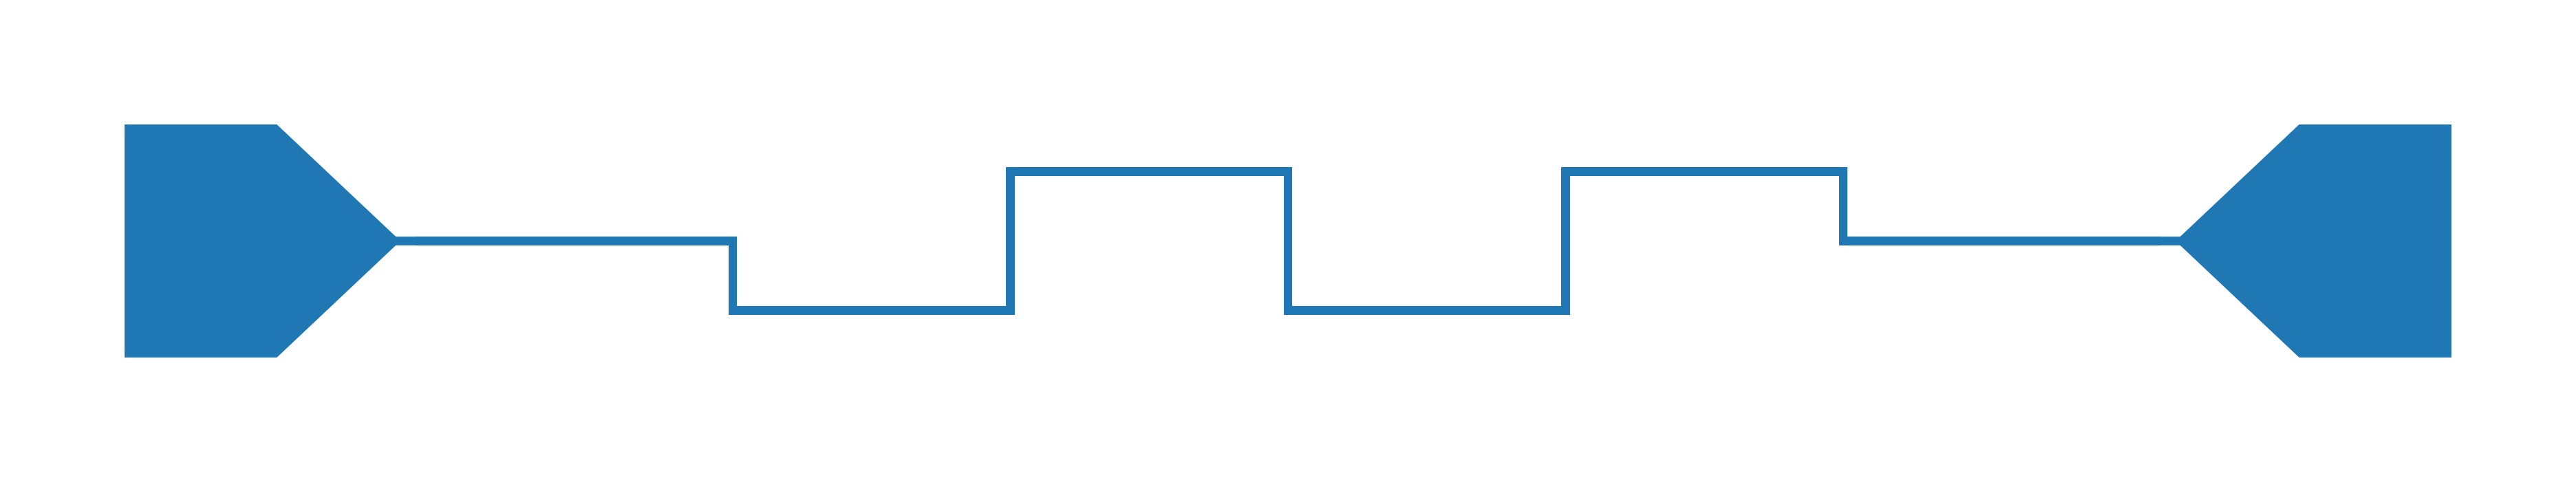

In [14]:
#@title 600-DPI preview (layer/datatype grouped)
import os, numpy as np, gdstk, matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection
from IPython.display import Image, display

# Locate most recent GDS if path changed
gds_path = str(GDS_PATH) if 'GDS_PATH' in globals() and os.path.isfile(GDS_PATH) else ""
if not gds_path:
    cands = []
    for root, _, files in os.walk("/content"):
        for f in files:
            if f.lower().endswith(".gds"):
                cands.append(os.path.join(root, f))
    gds_path = max(cands, key=os.path.getmtime)

lib = gdstk.read_gds(gds_path)
top = lib.top_level()[0]
flat = top.copy(name=f"{top.name}_FLAT"); flat.flatten()

by_spec = {}
for poly in flat.polygons:
    key = (poly.layer, poly.datatype)
    by_spec.setdefault(key, []).append(np.asarray(poly.points, dtype=float))

fig, ax = plt.subplots(figsize=(8,5), dpi=100)
for _, verts in by_spec.items():
    if verts:
        ax.add_collection(PolyCollection(verts, linewidth=0.4))  # default color cycle
(bb_min, bb_max) = flat.bounding_box()
xmin, ymin = bb_min; xmax, ymax = bb_max
pad = 0.05*max(xmax-xmin, ymax-ymin)
ax.set_xlim(xmin-pad, xmax+pad); ax.set_ylim(ymin-pad, ymax+pad)
ax.set_aspect("equal"); ax.axis("off")

png_out = os.path.splitext(gds_path)[0] + "_preview_600dpi.png"
pdf_out = os.path.splitext(gds_path)[0] + "_preview.pdf"
fig.savefig(png_out, dpi=600, bbox_inches="tight", pad_inches=0.02)
fig.savefig(pdf_out,        bbox_inches="tight", pad_inches=0.02)
plt.close(fig)

print("GDS:", gds_path)
print("Saved PNG:", png_out)
print("Saved PDF:", pdf_out)
display(Image(png_out))


In [17]:
# @title Export CPW with gaps, rounded bends, and ground plane (pure GDSTK)
from pathlib import Path
import math
import numpy as np
import shapely.geometry as sgeom
import shapely.ops as sops
import gdstk

# ----- Helper: parse "8mm", "300um" → microns -----
def to_um(val, default_um=0.0):
    try:
        return float(val)
    except Exception:
        s = str(val).strip().lower()
        if s.endswith("mm"):
            return float(s[:-2]) * 1_000.0
        if s.endswith("um"):
            return float(s[:-2])
        if s.endswith("nm"):
            return float(s[:-2]) * 1e-3
        return float(default_um)

# ----- 1) Recover key knobs from your design (used earlier) -----
cpw_w_um = to_um(design.variables.get("cpw_width", "10um"), 10.0)
cpw_g_um = to_um(design.variables.get("cpw_gap",   "6um"),   6.0)

# If you used names from the prior cell, these exist; else just set constants here:
PAD_GAP_UM = globals().get("PAD_GAP_UM", 144.0)

# Chip size (centered box)
sx_um = to_um(design.chips.main.size["size_x"], 1000.0)  # default 8 mm if missing
sy_um = to_um(design.chips.main.size["size_y"], 600.0)  # default 4 mm
chip_box = sgeom.box(-sx_um/2, -sy_um/2, sx_um/2, sy_um/2)

# ----- 2) Build Shapely sets: conductor polygons, CPW gap rings -----
conductor_geoms = []   # center trace + pads
gap_geoms       = []   # rings: (width/2 + gap) buffer minus (width/2) buffer

# 2a) Center trace from qgeometry PATH: buffer twice (round, quad_segs=64)
if "path" in design.qgeometry.tables:
    for _, row in design.qgeometry.tables["path"].iterrows():
        geom = row["geometry"]                # LineString
        width_um = to_um(row.get("width", cpw_w_um), cpw_w_um)

        core  = geom.buffer(width_um/2, cap_style='round', join_style='round', quad_segs=64)
        outer = geom.buffer(width_um/2 + cpw_g_um, cap_style='round', join_style='round', quad_segs=64)
        ring  = outer.difference(core)

        conductor_geoms.append(core)
        gap_geoms.append(ring)

# 2b) Pads from qgeometry POLY: add as conductors; build pad gap as ring
if "poly" in design.qgeometry.tables:
    poly_df = design.qgeometry.tables["poly"].copy()
    for _, row in poly_df.iterrows():
        geom = row["geometry"]                # Polygon / MultiPolygon for pads/tapers/etc.
        # Add all non-subtract polys as metal
        if not bool(row.get("subtract", False)):
            conductor_geoms.append(geom)
            # Surround pads with PAD_GAP_UM ring (optional but requested)
            if PAD_GAP_UM > 0:
                pad_ring = geom.buffer(PAD_GAP_UM, cap_style='round', join_style='round', quad_segs=64).difference(geom)
                gap_geoms.append(pad_ring)

# Union for robustness
conductor_un  = sops.unary_union(conductor_geoms) if conductor_geoms else sgeom.GeometryCollection()
gap_un        = sops.unary_union(gap_geoms)       if gap_geoms       else sgeom.GeometryCollection()

# Ground plane: chip rectangle minus (conductor + gaps)
gnd_un = chip_box.difference(sops.unary_union([conductor_un, gap_un]))

# ----- 3) Write to GDS (positive metal layer) -----
OUT_DIR = Path("/content/out_gds"); OUT_DIR.mkdir(parents=True, exist_ok=True)
GDS_PATH = OUT_DIR / "cpw_meander_with_pads_and_ground.gds"

def shapely_to_gdstk(geom, layer, datatype=0):
    polys = []
    if geom.is_empty:
        return polys
    if geom.geom_type == "Polygon":
        polys.append(gdstk.Polygon(np.asarray(geom.exterior.coords), layer=layer, datatype=datatype))
        for hole in geom.interiors:
            polys.append(gdstk.Polygon(np.asarray(hole.coords), layer=layer, datatype=datatype))
    elif geom.geom_type == "MultiPolygon":
        for sub in geom.geoms:
            polys.extend(shapely_to_gdstk(sub, layer, datatype))
    else:
        # Attempt polygonization for line-y leftovers (shouldn’t happen here)
        try:
            for sub in sops.polygonize(geom):
                polys.extend(shapely_to_gdstk(sub, layer, datatype))
        except Exception:
            pass
    return polys

# Layers: separate ground and trace for clarity
L_TRACE = 1
L_GND   = 2

lib  = gdstk.Library(unit=1e-6, precision=1e-9)
cell = gdstk.Cell("CPW_WITH_PADS_AND_GROUND"); lib.add(cell)

for p in shapely_to_gdstk(conductor_un, layer=L_TRACE):
    cell.add(p)
for p in shapely_to_gdstk(gnd_un,       layer=L_GND):
    cell.add(p)

lib.write_gds(str(GDS_PATH))
print("Wrote:", GDS_PATH)


Wrote: /content/out_gds/cpw_meander_with_pads_and_ground.gds


Saved: /content/out_gds/cpw_meander_with_pads_and_ground_preview_600dpi.png
Saved: /content/out_gds/cpw_meander_with_pads_and_ground_preview.pdf


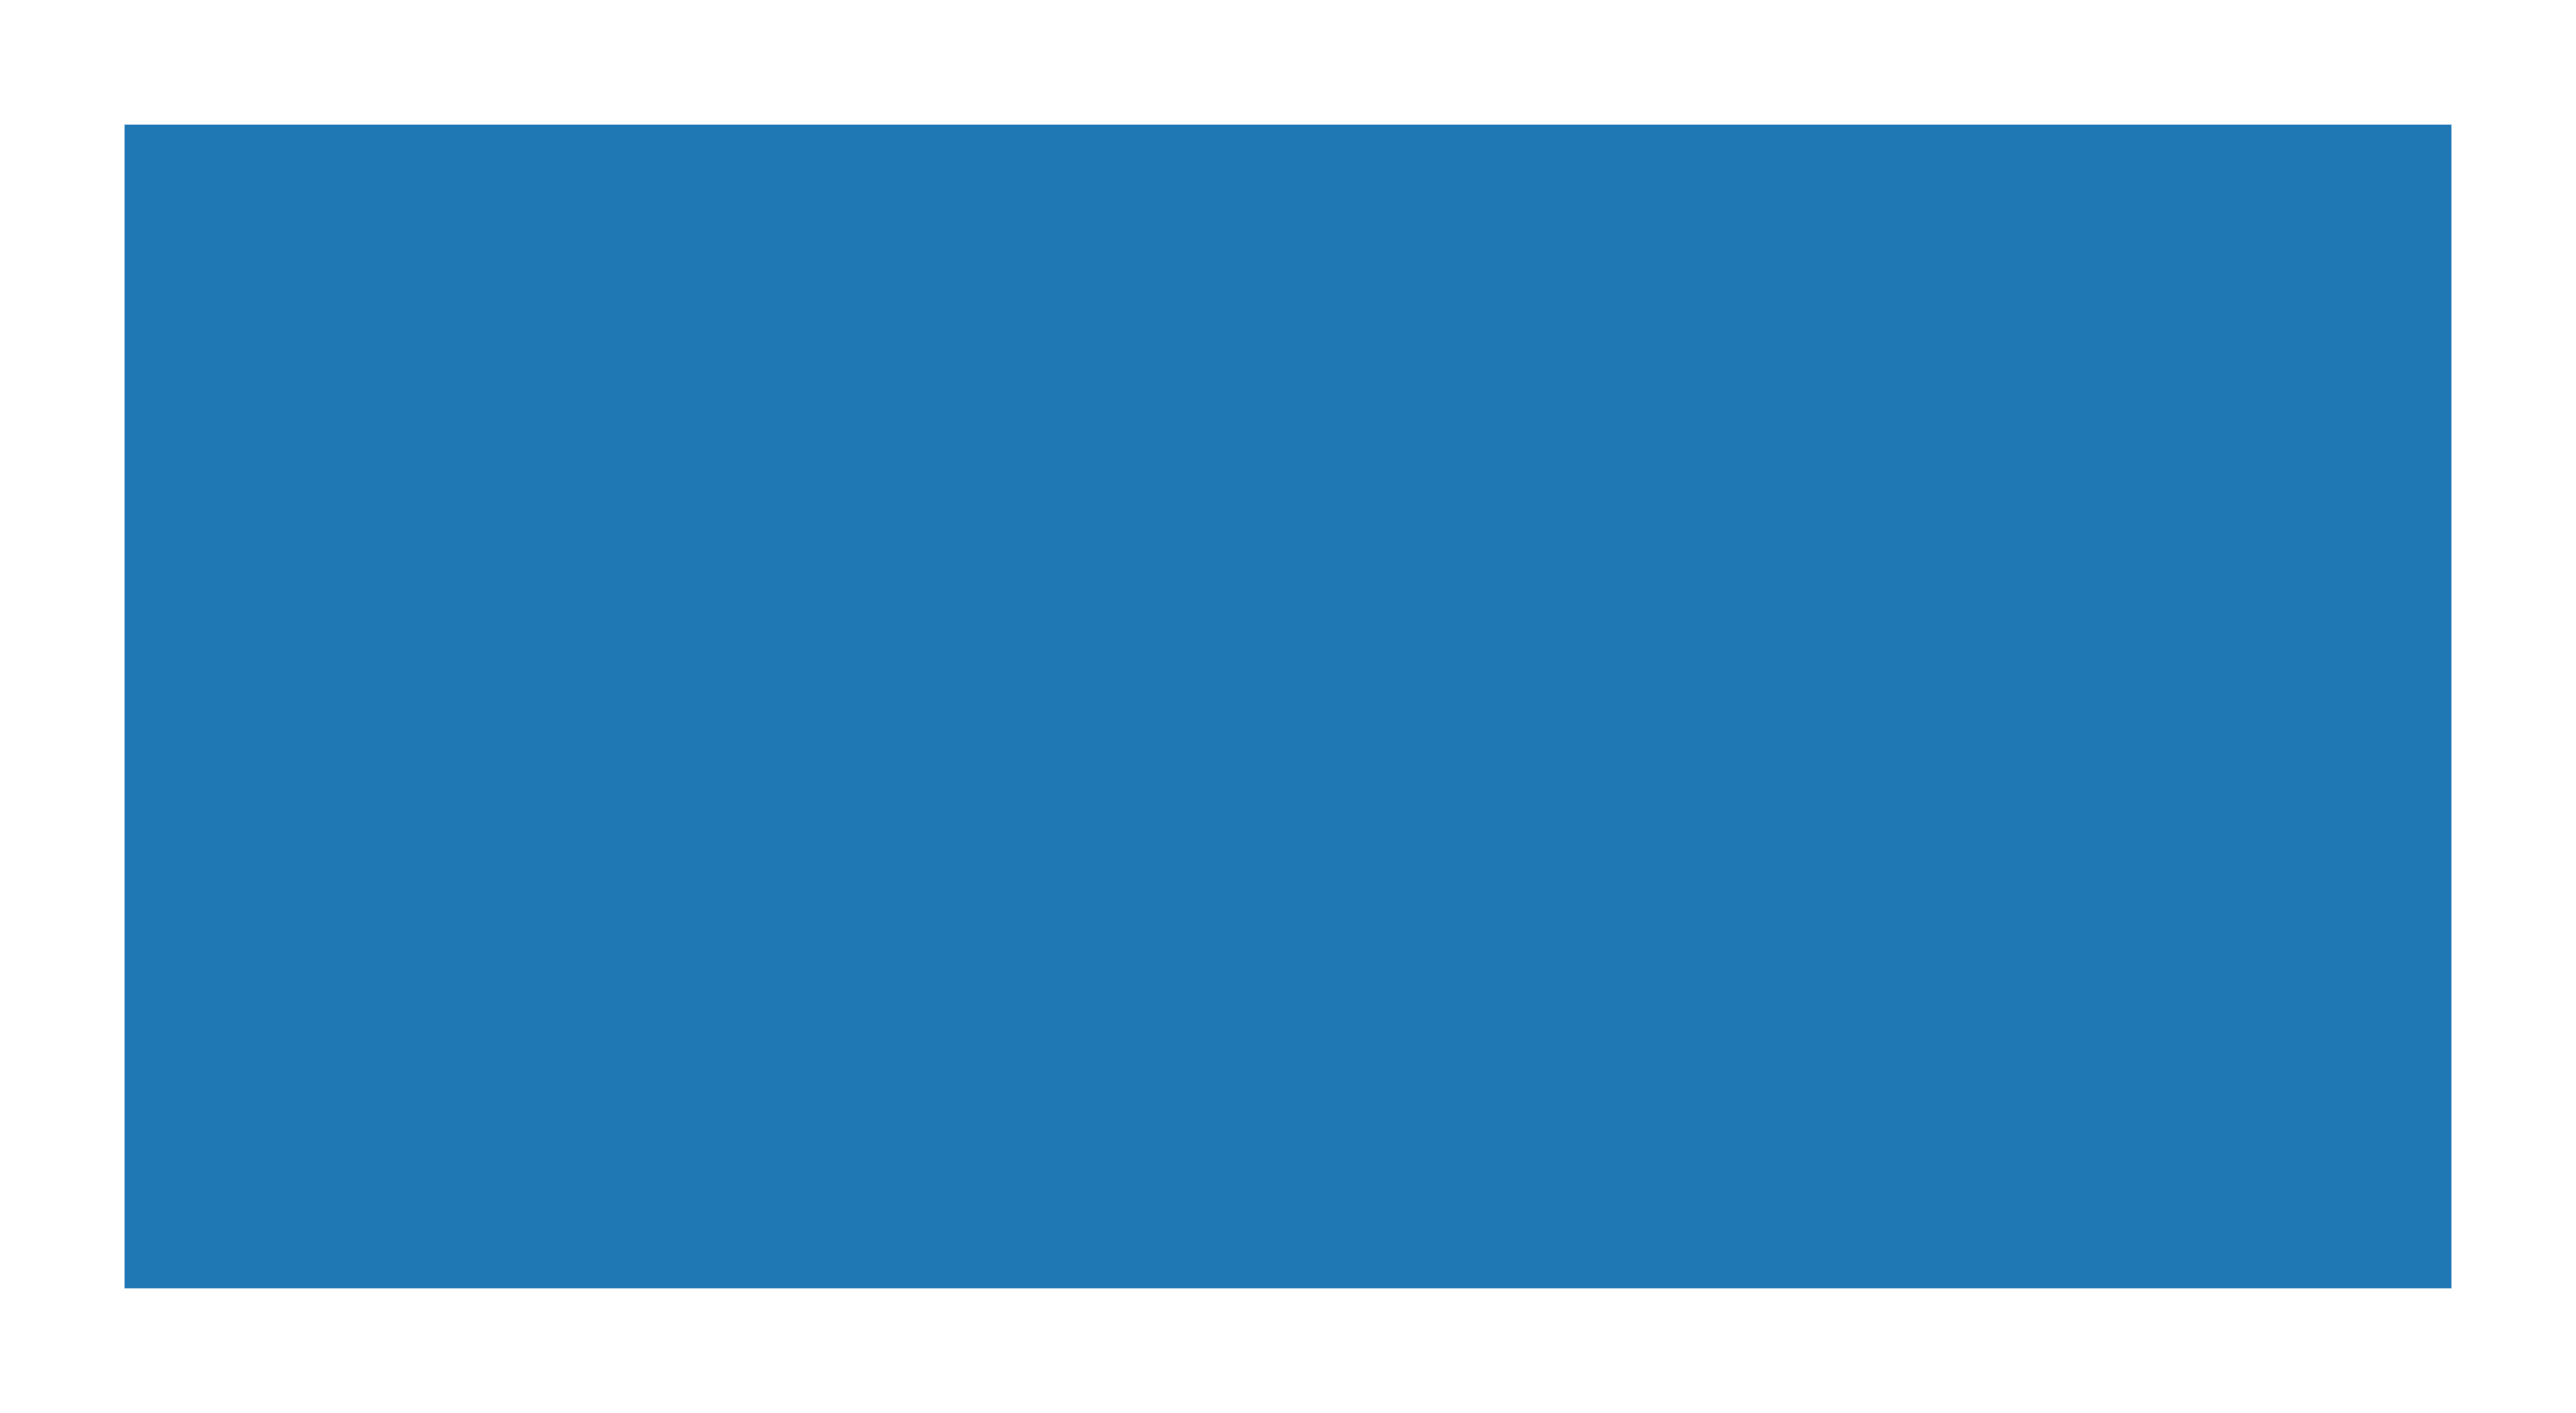

In [18]:
# @title 600-DPI preview (ground vs trace split)
import os, numpy as np, gdstk, matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection
from IPython.display import Image, display

# Locate newest GDS under /content if path changed
gds_path = str(GDS_PATH) if 'GDS_PATH' in globals() and os.path.isfile(GDS_PATH) else ""
if not gds_path:
    cands=[]
    for root,_,files in os.walk("/content"):
        for f in files:
            if f.lower().endswith(".gds"):
                cands.append(os.path.join(root,f))
    if not cands: raise FileNotFoundError("No .gds found.")
    gds_path = max(cands, key=os.path.getmtime)

lib = gdstk.read_gds(gds_path)
top = lib.top_level()[0]
flat = top.copy(name=f"{top.name}_FLAT"); flat.flatten()

by_spec = {}
for poly in flat.polygons:
    key = (poly.layer, poly.datatype)
    by_spec.setdefault(key, []).append(np.asarray(poly.points, dtype=float))

fig, ax = plt.subplots(figsize=(8,5), dpi=100)
for key, verts in sorted(by_spec.items()):
    if verts:
        ax.add_collection(PolyCollection(verts, linewidth=0.4))  # default color cycle

(bb_min, bb_max) = flat.bounding_box()
xmin, ymin = bb_min; xmax, ymax = bb_max
pad = 0.05*max(xmax-xmin, ymax-ymin)
ax.set_xlim(xmin-pad, xmax+pad); ax.set_ylim(ymin-pad, ymax+pad)
ax.set_aspect("equal"); ax.axis("off")

png_out = os.path.splitext(gds_path)[0] + "_preview_600dpi.png"
pdf_out = os.path.splitext(gds_path)[0] + "_preview.pdf"
fig.savefig(png_out, dpi=600, bbox_inches="tight", pad_inches=0.02)
fig.savefig(pdf_out,        bbox_inches="tight", pad_inches=0.02)
plt.close(fig)
print("Saved:", png_out)
print("Saved:", pdf_out)
display(Image(png_out))
